# Harmonization with Carbon Budget Conservation

We seek an emissions trajectory consistent with a provided historical emissions timeseries that closely matches a modeled result and maintains the overall carbon budget consistent with that model result.

First, model and history data are read in. The model is then harmonized. Finally, output is analyzed.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyomo.environ as pyomo

import aneris
from aneris.tutorial import load_data

%matplotlib inline

The `driver` is used to execute the harmonization. It will handle the data formatting needed to execute the harmonizaiton operation and stores the harmonized results until they are needed.

Some logging output is provided. It can be suppressed with 

```
aneris.logger().setLevel('WARN')
```

In [2]:
model, hist, driver = load_data()

Since the default function which chooses, which method to use does not apply the `budget` method, we specify overrides to use budget for all the variables in the model data.

In [3]:
driver.overrides = model[["Model", "Scenario", "Region", "Variable", "Unit"]].assign(Method="budget")
driver.overrides.head()

,Model,Scenario,Region,Variable,Unit,Method
0,model,sspn,regionc,prefix|Emissions|BC|sector1|suffix,Mt BC/yr,budget
1,model,sspn,regionc,prefix|Emissions|BC|sector2|suffix,Mt BC/yr,budget
2,model,sspn,regionc,prefix|Emissions|BC|suffix,Mt BC/yr,budget
3,model,sspn,World,prefix|Emissions|BC|sector1|suffix,Mt BC/yr,budget
4,model,sspn,World,prefix|Emissions|BC|sector2|suffix,Mt BC/yr,budget


In [4]:
for scenario in driver.scenarios():
    driver.harmonize(scenario)
harmonized, metadata, diagnostics = driver.harmonized_results()

INFO:root:Downselecting prefix|suffix variables
INFO:root:Translating to standard format
INFO:root:Aggregating historical values to native regions
INFO:root:Harmonizing (with example methods):
region  gas  sector                 units
World   BC   prefix|sector1|suffix  kt       budget
             prefix|sector2|suffix  kt       budget
             prefix|suffix          kt       budget
Name: method, dtype: object
INFO:root:                                         method            default override
region  gas sector                units                                    
regionc BC  prefix|sector1|suffix kt     budget  reduce_ratio_2050   budget
            prefix|sector2|suffix kt     budget  reduce_ratio_2050   budget
            prefix|suffix         kt     budget  reduce_ratio_2050   budget
INFO:root:and override methods:
INFO:root:region   gas  sector                 units
World    BC   prefix|sector1|suffix  kt       budget
              prefix|sector2|suffix  kt       budget


All data of interest is combined in order to easily view it. We will specifically investigate output for the `World` in this example. A few operations are performed in order to get the data into a plotting-friendly format.

In [5]:
data = pd.concat([hist, model, harmonized], sort=True)
df = data[data.Region == 'World']

In [6]:
df = pd.melt(df, id_vars=aneris.iamc_idx, value_vars=aneris.numcols(df), 
             var_name='Year', value_name='Emissions')
df['Label'] = df['Model'] + ' ' + df['Variable']

In [7]:
df.head()

,Model,Scenario,Region,Variable,Year,Emissions,Label
0,History,scen,World,prefix|Emissions|BC|sector1|suffix,2000,4.0,History prefix|Emissions|BC|sector1|suffix
1,History,scen,World,prefix|Emissions|BC|sector2|suffix,2000,6.0,History prefix|Emissions|BC|sector2|suffix
2,History,scen,World,prefix|Emissions|BC|suffix,2000,10.0,History prefix|Emissions|BC|suffix
3,model,sspn,World,prefix|Emissions|BC|sector1|suffix,2000,NaN,model prefix|Emissions|BC|sector1|suffix
4,model,sspn,World,prefix|Emissions|BC|sector2|suffix,2000,NaN,model prefix|Emissions|BC|sector2|suffix


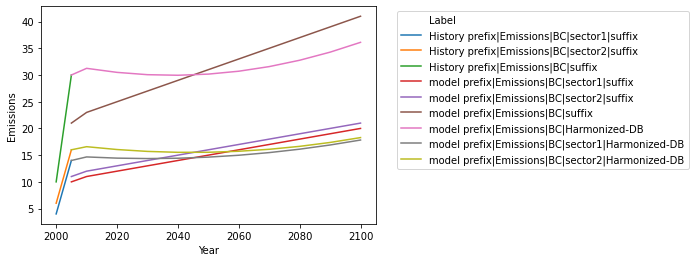

In [8]:
sns.lineplot(x='Year', y='Emissions', hue='Label', data=df.assign(Year=df.Year.astype(int)))
plt.legend(bbox_to_anchor=(1.05, 1))

## Calculation details


In the following we explain the method in more detail by harmonizing manually only the total `prefix|Emissions|BC|suffix` in the `World` region

In [9]:
ms = df.loc[(df.Variable == 'prefix|Emissions|BC|suffix') & (df.Model == 'model')].set_index('Year')['Emissions'].dropna()
hs = df.loc[(df.Variable == 'prefix|Emissions|BC|suffix') & (df.Model == 'History')].set_index('Year')['Emissions'].dropna()


We calculate the carbon budget from the model and historical data by estimating the integral between discrete data points using the Riemann trapezoidal sum. 

In [10]:
def calc_budget(data):
    # trapezoid rule reimann sum
    dx = data.index.to_series().astype(int).diff()
    y1 = data
    dy = data.diff()
    budget = (dx * (y1 - .5 * dy)).iloc[1:].sum()
    return budget

calc_budget(ms) / 1e3 # in Gt BC

2.99

### Harmonization via Optimization

We create a model that matches as close as possible the dynamic rates of change of the modeled emission trajectory but adhering to the original carbon budget of the model.

This takes in as data:
- the year values of the harmonized data
- the original model values (unharmonized)
- the historical value to be harmonized to (assumed to occur in the first year)
- the total carbon budget to match

In [11]:
years = ms.index[ms.index.astype(int) >= int(hs.index[-1])]
model_vals = ms.loc[years]
hist_val = hs.iloc[-1]
budget = calc_budget(model_vals)

The model itself minimizes the $L_2$ norm of the rates of change:

$$
\min_{x_i} \sum_{i \in |I - 1|} \big( \frac{m_{i+1} - m_i}{y_{i + 1} - y_{i}} - \frac{x_{i+1} - x_i}{y_{i + 1} - y_{i}} \big)^2
$$

Given model results, $m_i$, years, $y_i$, and harmonized results, $x_i$.

In [12]:
model = pyomo.ConcreteModel()
model.x = pyomo.Var(list(years), initialize=0, domain=pyomo.Reals)
x = pd.Series([model.x[y] for y in years], years)

delta_years = years.to_series().astype(int).diff()
delta_x = x.diff()
delta_m = model_vals.diff()

def l2_norm():
    return pyomo.quicksum(((delta_m / delta_years - delta_x / delta_years) ** 2).dropna())

model.obj = pyomo.Objective(expr=l2_norm(), sense=pyomo.minimize)

The historical value must match

$$
x_0 = h
$$

In [13]:
model.hist_val = pyomo.Constraint(expr=model.x[years[0]] == hist_val)

And the carbon budget must be maintained, using a trapezoidal rule Reimann sum,

$$
\sum_{i \in |I - 1|} (y_{i + 1} - y_{i}) \big( x_i + 0.5 (x_{i+1} - x_i) \big) = B
$$

In [14]:
model.budget = pyomo.Constraint(expr=calc_budget(x) == budget)

The model is solved with IPOPT and compared with the original trajectory.

In [15]:
solver = pyomo.SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2, 'Number of variables': 11, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.0256350040435791}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

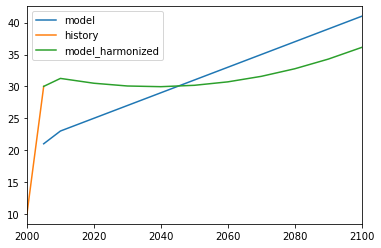

In [16]:
data = pd.concat(
    dict(
        model=ms,
        history=hs,
        model_harmonized=pd.Series([pyomo.value(model.x[y]) for y in years], years)
    ),
    axis=1,
    sort=True
)
data.index = data.index.astype(int)
data.plot.line()